# MT Data-conditioned VAE

In [23]:
# pip install tensorflow

In [24]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [26]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])*1e-3
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [27]:
depths=np.append(depths,[554,573])
print(depths.shape)

(31,)


In [28]:
times = np.append(times,16.055*1e-3)
print(len(times))

16


In [29]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [30]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

thicknesses (31,)


In [31]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw = np.load('Line1_Central_Observations.npy')
x_validate_raw = np.load('Line3_Central_Observations.npy')
x_test1_raw = np.load('Line2_Central_Observations.npy')
#print(x_train_raw_log)

# x_train_raw = network.model_to_tanhs(x_train_raw_log)
# x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
# x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

In [32]:
x_train1 = x_train[0:1000,]
x_validate1 = x_validate[0:1000,]
x_train_raw1 = x_train_raw[0:1000,]
x_validate_raw1 = x_validate_raw[0:1000,]
x_test_raw1 = x_test1_raw[0:1000,]
# plt.plot(x_train_raw1[0],np.append(0,depths))

In [33]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
print(train_data)
print("train data", train_data.shape)
print('.........')

raw_train_data = -x_train_raw1
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)
print(raw_train_data)
validate_data = x_validate1[:,:,0]
raw_validate_data = x_validate_raw1

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

[[-0.3717506  -0.35877268 -0.33019401 ... -0.5399025  -0.53984124
  -0.53986997]
 [-0.35924058 -0.3459848  -0.3168738  ... -0.53991749 -0.53985802
  -0.53988592]
 [-0.34984667 -0.33582953 -0.30524038 ... -0.53992124 -0.53986095
  -0.53988923]
 ...
 [-0.17945237 -0.15864629 -0.12139163 ... -0.53989797 -0.53986838
  -0.53988226]
 [-0.17917573 -0.1583147  -0.12093393 ... -0.5398954  -0.53986531
  -0.53987942]
 [-0.17774358 -0.15715603 -0.12023772 ... -0.53989532 -0.53986605
  -0.53987978]]
train data (1000, 32)
.........
raw_train_data (1000, 16)
[[-7.947291 -7.020374 -6.58563  ... -0.582863 -0.272842 -0.272842]
 [-7.903422 -6.97731  -6.545748 ... -0.579572 -0.271219 -0.271219]
 [-7.858701 -6.934481 -6.506257 ... -0.576283 -0.269532 -0.269532]
 ...
 [-8.692881 -7.881269 -7.458712 ... -0.610495 -0.270002 -0.270002]
 [-8.713656 -7.898522 -7.477573 ... -0.616137 -0.273557 -0.273557]
 [-8.745406 -7.926272 -7.506173 ... -0.622007 -0.277042 -0.277042]]


In [34]:
# plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [35]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [36]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
# plt.plot(train_data[0],np.append(0,depths))

(1000, 32)
(1000, 16)


In [37]:
# # Create batches and shuffle
BATCH_SIZE = 10

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
# print(rel_data_std, model_std_vec)

In [38]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [39]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

thicknesses (31,)


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [40]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, 32))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
print(network.predict_tanh(random_train))
# predict their data
# print(n_cells)
random_data = network.predict_tanh(random_train.reshape(16, 32, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
# print('n_data',network.n_data)
random_data1 = random_data[:,:16]
data_input = tf.reshape(random_data1,(16,network.n_time))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

tf.Tensor(
[[-6.4519067e+00 -1.9955688e+00 -1.2270043e+00 -8.1872606e-01
  -5.6150544e-01 -3.9858988e-01 -2.8229943e-01 -1.9504942e-01
  -1.2835330e-01 -8.1276245e-02 -5.1462404e-02 -3.1746581e-02
  -1.7384924e-02 -8.0267610e-03 -2.7871251e-03 -2.7871251e-03]
 [-6.6047459e+00 -2.0472448e+00 -1.2529502e+00 -8.3382708e-01
  -5.7135260e-01 -4.0563199e-01 -2.8730571e-01 -1.9852275e-01
  -1.3070612e-01 -8.2831740e-02 -5.2460171e-02 -3.2331795e-02
  -1.7674064e-02 -8.1432983e-03 -2.8210252e-03 -2.8210252e-03]
 [-6.6489186e+00 -2.0858996e+00 -1.2763265e+00 -8.4819055e-01
  -5.8048564e-01 -4.1215497e-01 -2.9238644e-01 -2.0237809e-01
  -1.3327461e-01 -8.4264867e-02 -5.3186297e-02 -3.2747500e-02
  -1.7925804e-02 -8.2754418e-03 -2.8730463e-03 -2.8730463e-03]
 [-6.7686739e+00 -2.1385887e+00 -1.3050450e+00 -8.6520708e-01
  -5.9137231e-01 -4.1948906e-01 -2.9721481e-01 -2.0550747e-01
  -1.3535406e-01 -8.5758366e-02 -5.4268561e-02 -3.3405818e-02
  -1.8232675e-02 -8.3848611e-03 -2.8982703e-03 -2.898270

In [41]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


47529

<Figure size 640x480 with 0 Axes>

In [42]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [43]:
epochs = 10

In [44]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(train_x)
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, train_term[0], train_term[1], train_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))


tanhs (10, 32, 1)
loss Tensor("StatefulPartitionedCall:0", shape=(), dtype=float32)
[<tf.Variable 'conv1d_9/kernel:0' shape=(3, 1, 8) dtype=float32>, <tf.Variable 'conv1d_9/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'conv1d_10/kernel:0' shape=(3, 8, 16) dtype=float32>, <tf.Variable 'conv1d_10/bias:0' shape=(16,) dtype=float32>, <tf.Variable 'conv1d_11/kernel:0' shape=(3, 16, 32) dtype=float32>, <tf.Variable 'conv1d_11/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'dense_6/kernel:0' shape=(96, 40) dtype=float32>, <tf.Variable 'dense_6/bias:0' shape=(40,) dtype=float32>, <tf.Variable 'dense_7/kernel:0' shape=(36, 64) dtype=float32>, <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'conv1d_transpose_15/kernel:0' shape=(3, 32, 32) dtype=float32>, <tf.Variable 'conv1d_transpose_15/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'conv1d_transpose_16/kernel:0' shape=(3, 16, 32) dtype=float32>, <tf.Variable 'conv1d_transpose_16/bias:0' shape=(16,) dtype=float32>,

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


tanhs (16, 32, 1)
d_pre tf.Tensor(
[[-5.25146961e+00 -2.65596795e+00 -1.84802127e+00 -1.29883707e+00
  -8.95033717e-01 -6.12338483e-01 -4.05547082e-01 -2.64367878e-01
  -1.71423614e-01 -1.11126073e-01 -7.07975179e-02 -4.13763449e-02
  -2.05972623e-02 -8.59605707e-03 -2.80075870e-03 -2.80075870e-03]
 [-6.40932465e+00 -3.54073167e+00 -2.35706806e+00 -1.51782119e+00
  -9.34531629e-01 -5.81931889e-01 -3.65430295e-01 -2.35349238e-01
  -1.54303759e-01 -1.01800680e-01 -6.54559284e-02 -3.80994491e-02
  -1.89015158e-02 -7.97193032e-03 -2.64310953e-03 -2.64310953e-03]
 [-4.36331749e+00 -2.42690825e+00 -1.75021434e+00 -1.25984633e+00
  -8.84357154e-01 -6.21299028e-01 -4.28861737e-01 -2.91943431e-01
  -1.94571316e-01 -1.25463665e-01 -7.71209896e-02 -4.35811877e-02
  -2.14672387e-02 -9.02575999e-03 -2.94347224e-03 -2.94347224e-03]
 [-5.90798616e+00 -2.95165658e+00 -1.92434812e+00 -1.25393307e+00
  -8.12937081e-01 -5.43040812e-01 -3.62748265e-01 -2.43140742e-01
  -1.62444979e-01 -1.07684180e-01 -6.9

c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:606: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(*ylims)


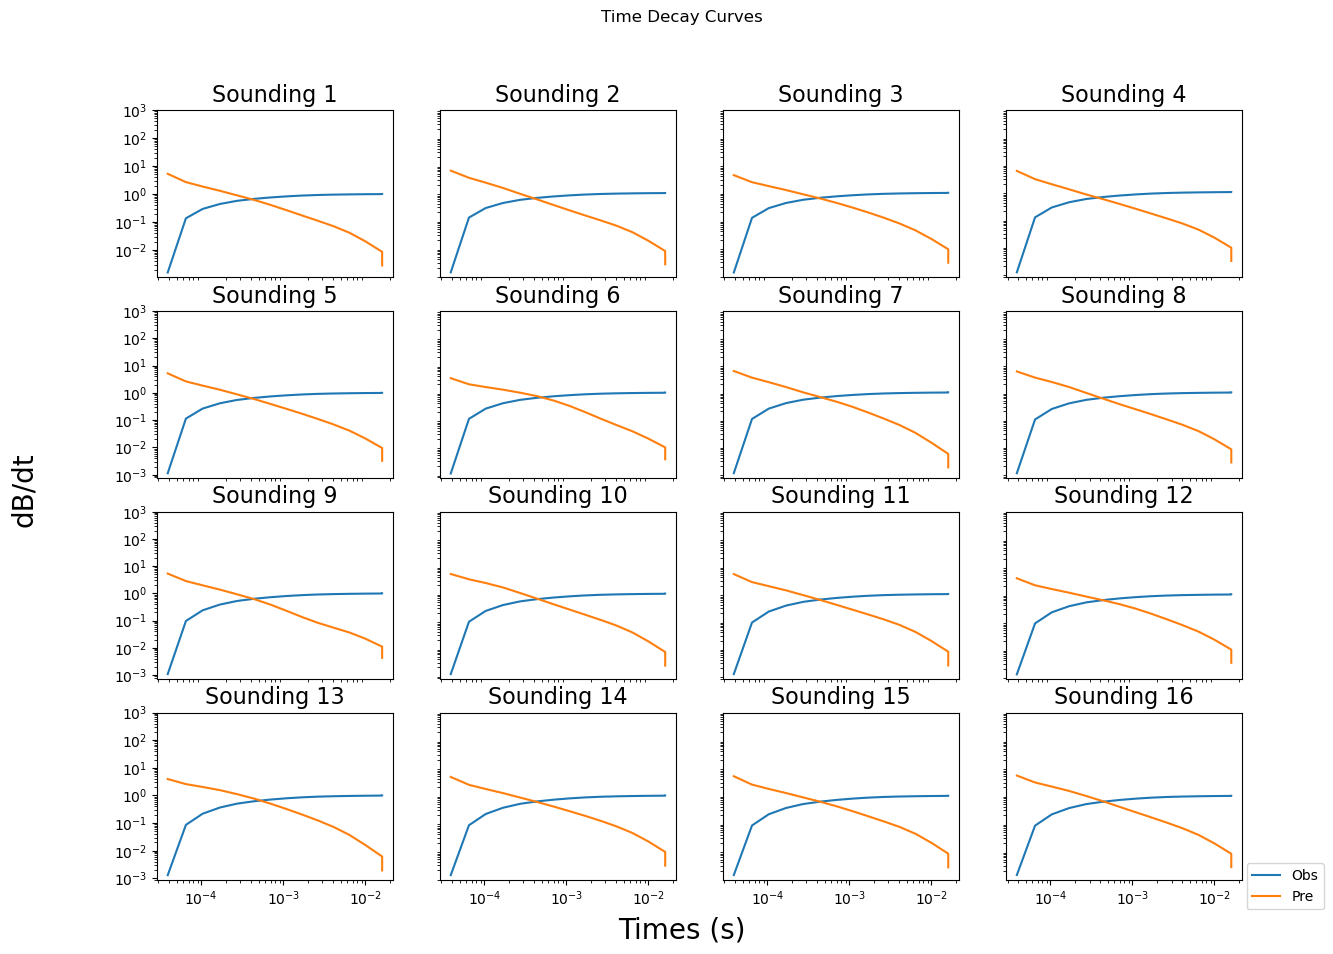

In [46]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

In [47]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

tanhs (16, 32, 1)
tf.Tensor(
[[-6.60399199e-01 -6.21016979e-01 -4.80111003e-01 -3.33528280e-01
  -2.13748604e-01 -1.23247653e-01 -6.93184584e-02 -4.30703163e-02
  -2.98498273e-02 -1.93351135e-02 -9.62976366e-03 -3.21233831e-03
  -5.69296069e-04 -1.36336312e-05 -1.36336312e-05]
 [-1.49348688e+00 -1.10411787e+00 -6.83994114e-01 -3.63179028e-01
  -1.76299900e-01 -7.81245828e-02 -3.68264914e-02 -2.35976428e-02
  -1.89689398e-02 -1.29957572e-02 -5.76765463e-03 -1.22745149e-03
  -1.71368010e-04 -1.77915674e-04 -1.77915674e-04]
 [-3.41008663e-01 -4.73887801e-01 -4.11655784e-01 -3.03871512e-01
  -2.09144056e-01 -1.36475295e-01 -8.95653367e-02 -6.12967014e-02
  -4.11987975e-02 -2.39346921e-02 -1.08336881e-02 -3.54143418e-03
  -7.50318170e-04 -7.04259146e-05 -7.04259146e-05]
 [-8.13067913e-01 -6.19303107e-01 -3.88725996e-01 -2.21564770e-01
  -1.23551756e-01 -6.55334592e-02 -3.76332700e-02 -2.70909220e-02
  -2.19258144e-02 -1.56460106e-02 -8.46802071e-03 -3.21496278e-03
  -7.60179013e-04 -9.94235

In [48]:
plt.close('all')
plt.clf()
gc.collect()

22887

<Figure size 640x480 with 0 Axes>

# Load networks

In [49]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [50]:
loss_terms = np.load(run+'/losses.npy')

In [51]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [52]:
plt.rcParams.update({'font.size': 18})

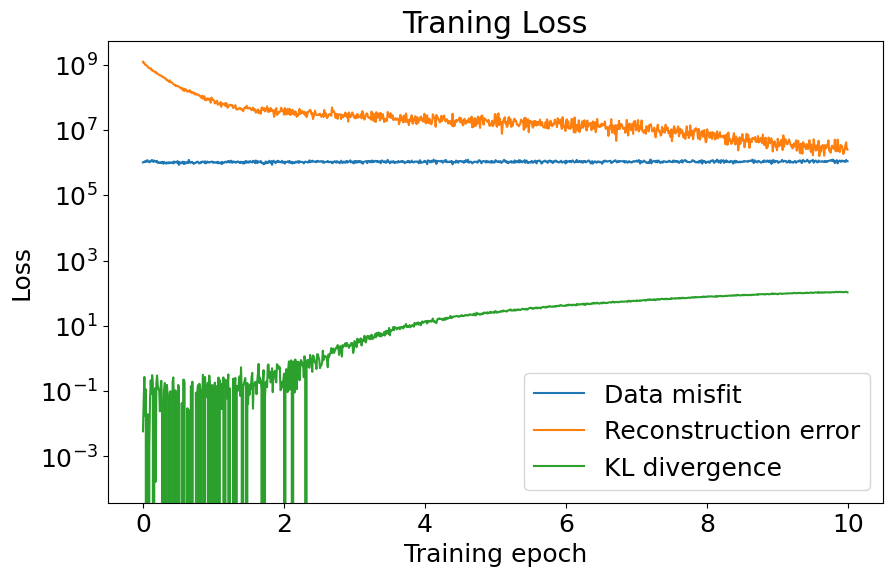

In [53]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

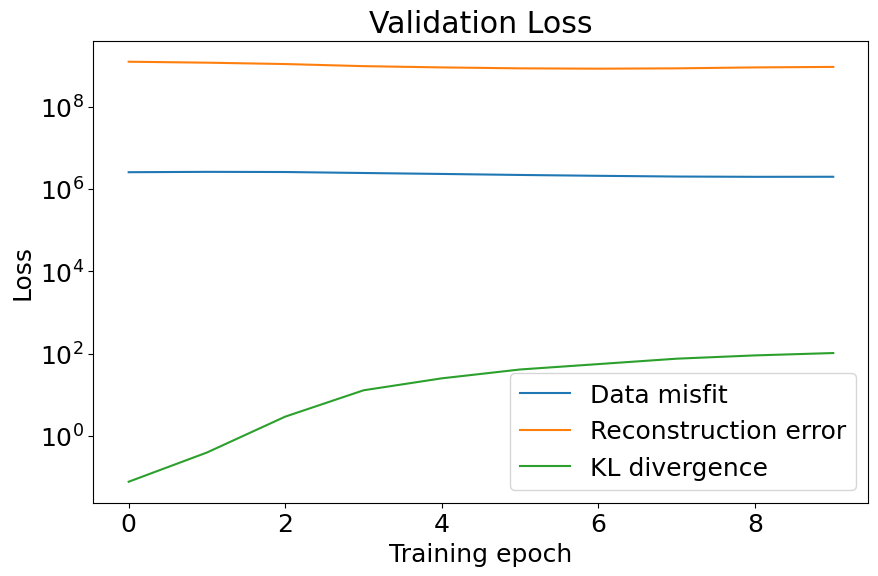

In [54]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [55]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [56]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(z_model)
network.plot_models(latent=zmd)

tf.Tensor(
[[ 1.265964    1.4135922  -2.9402373   1.1647533  -0.228273   -0.97570336
   2.9095697   4.076066   -1.3206981  -0.769455   -3.8106241   0.99088115
  -3.1829243  -2.4762583  -2.161       1.4011339  -0.57198215 -1.9319277
   0.574759    1.3194017 ]
 [ 1.2311226   1.4061546  -2.9069266   1.2237307  -0.2865211  -0.9970337
   2.93058     4.0132003  -1.3399457  -0.7836635  -3.8005266   1.0798612
  -3.1411884  -2.4080584  -2.1374774   1.4372914  -0.52556086 -1.9227345
   0.5074643   1.2649915 ]
 [ 1.2574544   1.4042455  -2.9399202   1.0844607  -0.14825886 -0.97131443
   2.8693905   4.0770407  -1.297576   -0.63598526 -3.7857578   0.994194
  -3.172699   -2.4736798  -2.1292365   1.4178188  -0.52940696 -1.9332348
   0.532274    1.3082001 ]
 [ 1.2378811   1.3825474  -2.9661608   1.1790746  -0.21158627 -0.99777657
   2.908194    3.8630583  -1.3272512  -0.6289732  -3.8659246   0.9977812
  -3.1329718  -2.3667874  -2.185248    1.453645   -0.5159743  -1.9353867
   0.49299517  1.3141706 ]
 [

In [57]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [58]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

tanhs (16, 32, 1)


(<tf.Tensor: shape=(), dtype=float32, numpy=-0.59404314>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3088224>)

In [59]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.5399266299885006>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.03254183984457575>)

tanhs (16, 32, 1)
d_pre tf.Tensor(
[[-2.49052024e+00 -1.35576653e+00 -1.04208016e+00 -8.24454308e-01
  -6.50692642e-01 -5.19838393e-01 -4.23795879e-01 -3.50393504e-01
  -2.77589321e-01 -1.98344201e-01 -1.21232875e-01 -6.10754639e-02
  -2.48948839e-02 -8.21246020e-03 -1.89926580e-03 -1.89926580e-03]
 [-2.48807454e+00 -1.35853636e+00 -1.04453659e+00 -8.26105654e-01
  -6.51506484e-01 -5.20089984e-01 -4.23752040e-01 -3.50281388e-01
  -2.77542144e-01 -1.98364928e-01 -1.21266097e-01 -6.10892922e-02
  -2.48933062e-02 -8.20749067e-03 -1.89638662e-03 -1.89638662e-03]
 [-2.48358512e+00 -1.34284246e+00 -1.03062177e+00 -8.15414071e-01
  -6.44633055e-01 -5.16650081e-01 -4.22611207e-01 -3.50119740e-01
  -2.77693689e-01 -1.98624477e-01 -1.21551961e-01 -6.13299832e-02
  -2.50469260e-02 -8.28416739e-03 -1.92429125e-03 -1.92429125e-03]
 [-2.49484324e+00 -1.35623443e+00 -1.04249012e+00 -8.25800419e-01
  -6.53728902e-01 -5.24662435e-01 -4.29433942e-01 -3.54929388e-01
  -2.79993743e-01 -1.98835656e-01 -1.2

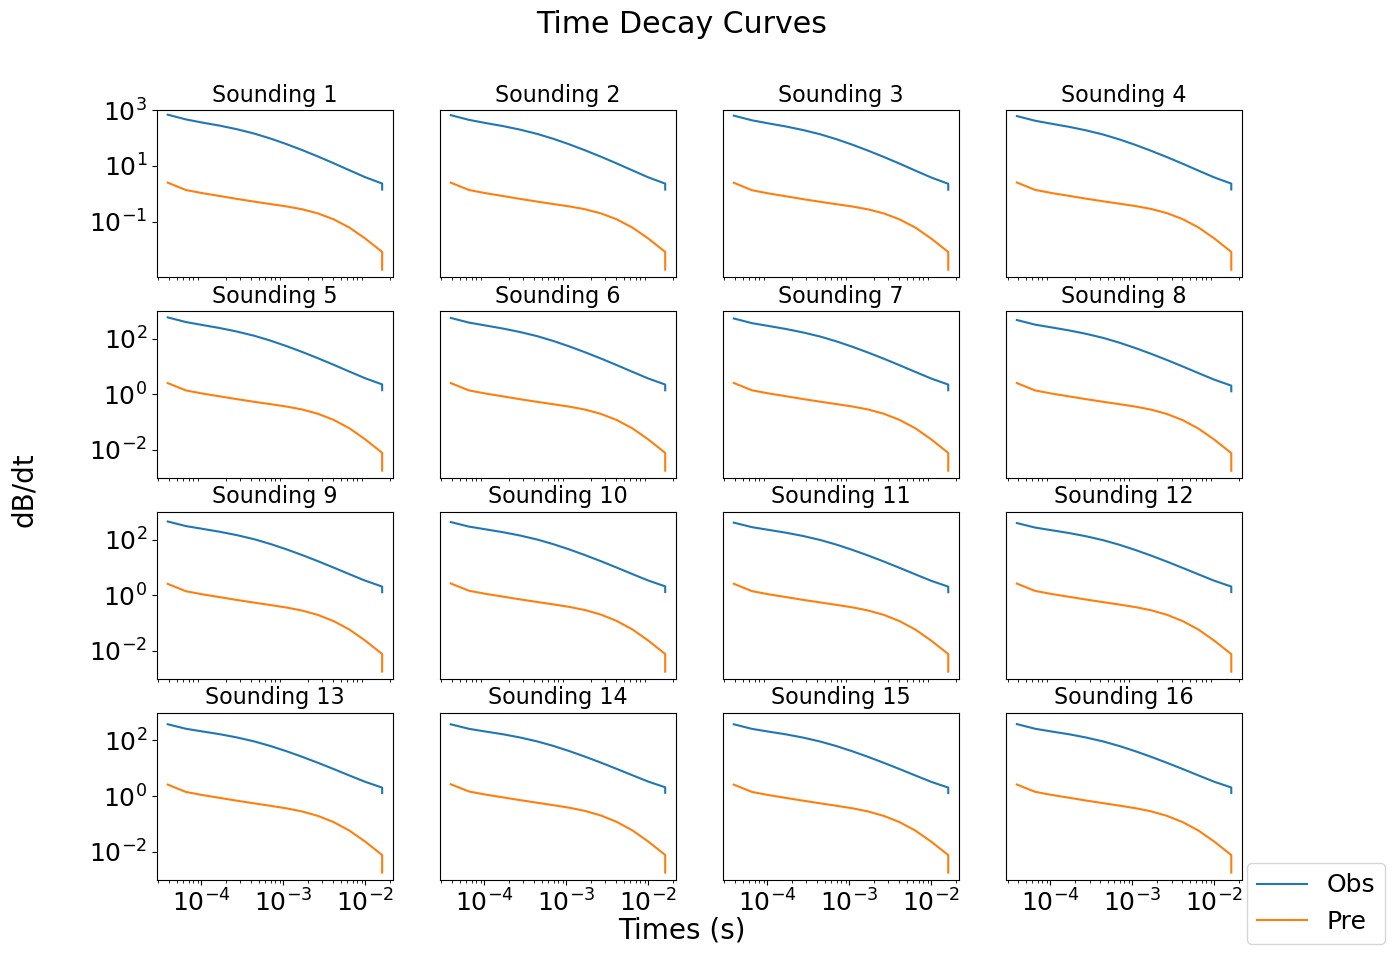

In [60]:
network.plot_data(latent=zmd)

tanhs (16, 32, 1)
tf.Tensor(
[[-7.486553   -6.906123   -6.4378753  -5.9687314  -5.4815025  -4.9694076
  -4.4432282  -3.8817024  -3.2785332  -2.640612   -1.9968214  -1.3883818
  -0.84825146 -0.34547126 -0.34547126]
 [-7.452692   -6.8753486  -6.406183   -5.937897   -5.452994   -4.942609
  -4.4185314  -3.859302   -3.258598   -2.623723   -1.9833713  -1.3791692
  -0.8422955  -0.34310538 -0.34310538]
 [-7.4012136  -6.829755   -6.363227   -5.900057   -5.421079   -4.9144363
  -4.3929615  -3.8360107  -3.2376313  -2.605717   -1.969092   -1.369455
  -0.8359581  -0.34060532 -0.34060532]
 [-7.3773894  -6.809515   -6.3410783  -5.8775787  -5.3997383  -4.893116
  -4.3710136  -3.8134549  -3.2151935  -2.585208   -1.9525533  -1.3582335
  -0.8288064  -0.3377936  -0.3377936 ]
 [-7.348802   -6.7853847  -6.316116   -5.8529754  -5.376583   -4.8704033
  -4.347726   -3.7894285  -3.1912024  -2.5633168  -1.9349482  -1.3462421
  -0.82126075 -0.3347955  -0.3347955 ]
 [-7.315248   -6.7560196  -6.2849517  -5.820757  

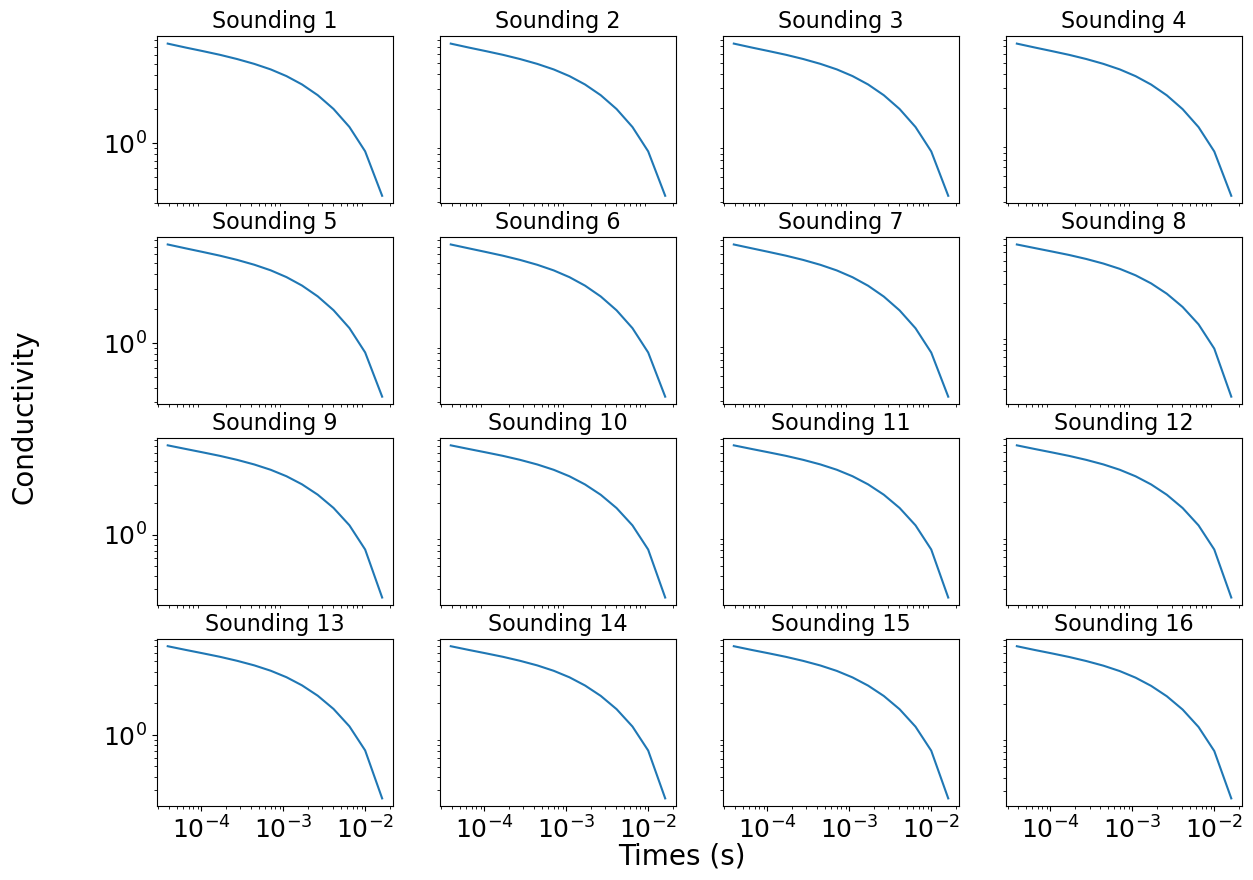

In [61]:
network.plot_residuals(latent=zmd, weighted=False)

# Randomize latent; does data still fit?

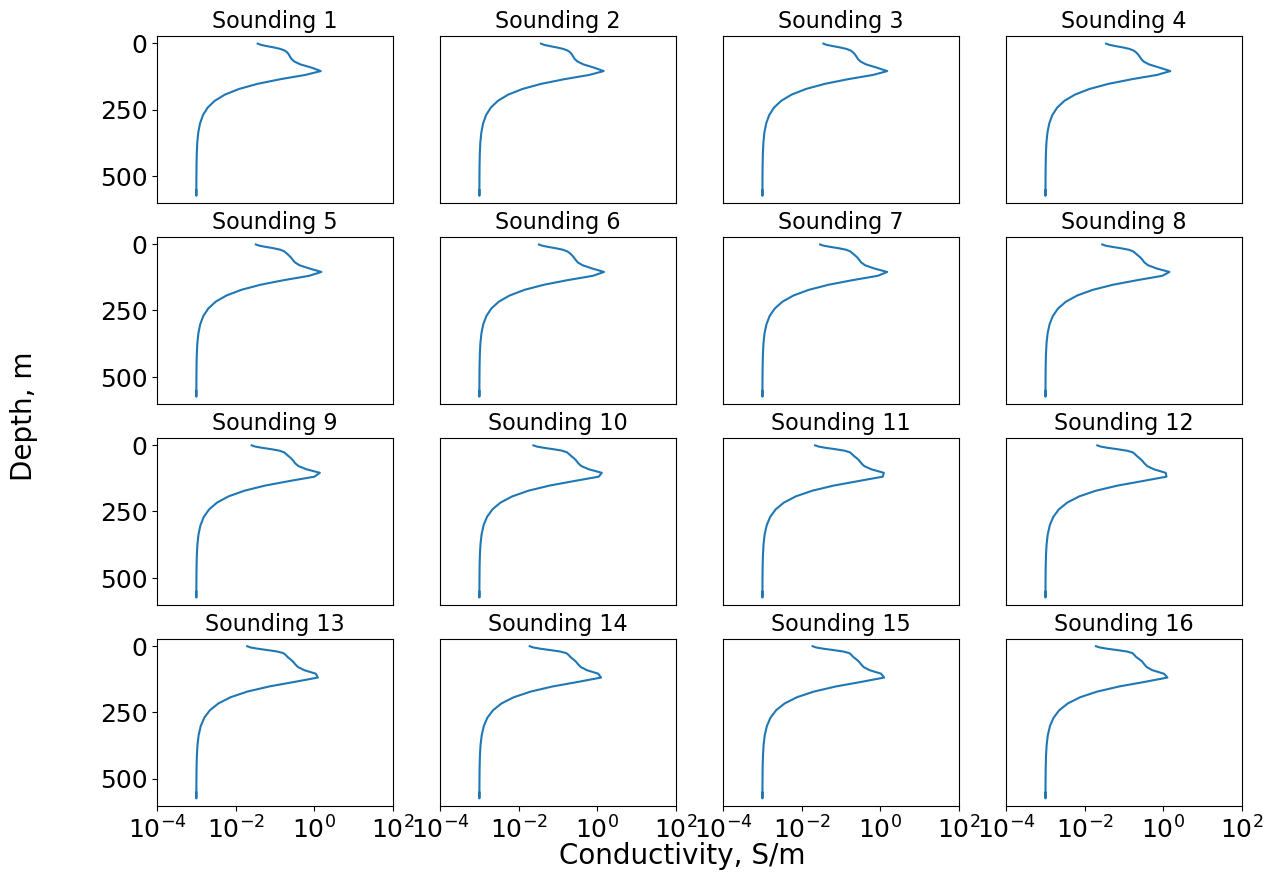

In [62]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0   :16])), depths=depths)

In [63]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [64]:
data0 = tf.tile(z_data[0:1],[16,1])
print(latent_input)
data0 = tf.cast(data0, tf.float32)
print(data0)
zmd2 = tf.concat((latent_input,data0),-1)

tf.Tensor(
[[-8.21040630e-01 -1.87033331e+00 -3.15637529e-01  5.95059931e-01
  -5.28799832e-01 -3.36213857e-01  1.54557765e-01 -8.77027929e-01
  -5.72458267e-01  7.40507066e-01  3.22158672e-02  1.27409172e+00
   5.61544001e-01 -3.78824770e-01  4.67423022e-01 -1.84850729e+00
   1.16076529e+00  1.54902542e+00 -1.04738319e+00  1.60275638e-01]
 [ 4.50515866e-01  4.39753473e-01 -5.52255452e-01  9.70487237e-01
  -9.22444388e-02  1.66306078e-01 -8.14915538e-01 -3.17014307e-01
  -1.21413183e+00  9.90915537e-01 -5.84398091e-01  9.38315034e-01
  -1.33178219e-01 -4.29583311e-01  5.60236871e-01  3.19555014e-01
   1.31736553e+00 -2.42678881e-01 -8.26739311e-01 -2.56593943e-01]
 [ 1.24025010e-01  1.27720165e+00 -6.59577489e-01 -8.46678436e-01
   6.24113023e-01 -7.53028929e-01  2.40457684e-01 -2.37532759e+00
   1.35693216e+00 -2.45755002e-01 -6.95904732e-01  6.07603848e-01
  -8.40784788e-01 -1.31723201e+00 -1.41548082e-01 -3.24857205e-01
  -1.21978056e+00 -7.04723597e-01  1.34089196e+00 -1.16240323e+

In [65]:
network.plot_models(latent=zmd2)

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


In [66]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

tanhs (16, 32, 1)


In [67]:
zmd2_logs.shape

(16, 32)

In [68]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [78]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
mean_true_cond = np.mean((train_data), axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(mean_true_cond)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

[-0.24151771 -0.21947058 -0.17732991 -0.12230009 -0.07127506 -0.0429982
 -0.04119428 -0.05054714 -0.05242483 -0.03683442 -0.00946447 -0.00410308
 -0.05108702 -0.13468561 -0.22398095 -0.30371648 -0.36960021 -0.42142711
 -0.46052734 -0.48882555 -0.5084379  -0.52141769 -0.52958882 -0.53446438
 -0.53721143 -0.53866798 -0.53939314 -0.53973136 -0.53987677 -0.53992405
 -0.53989085 -0.53990643]


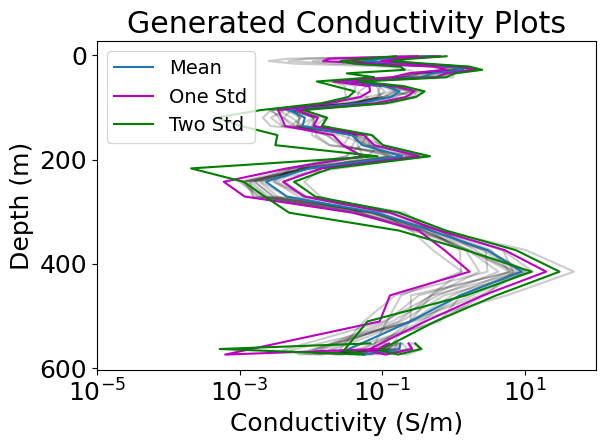

In [70]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()



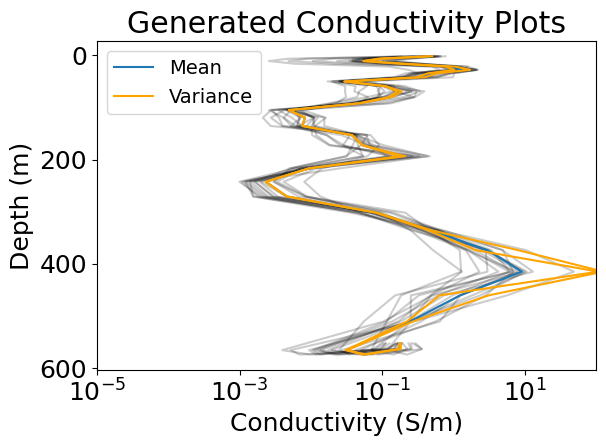

In [71]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

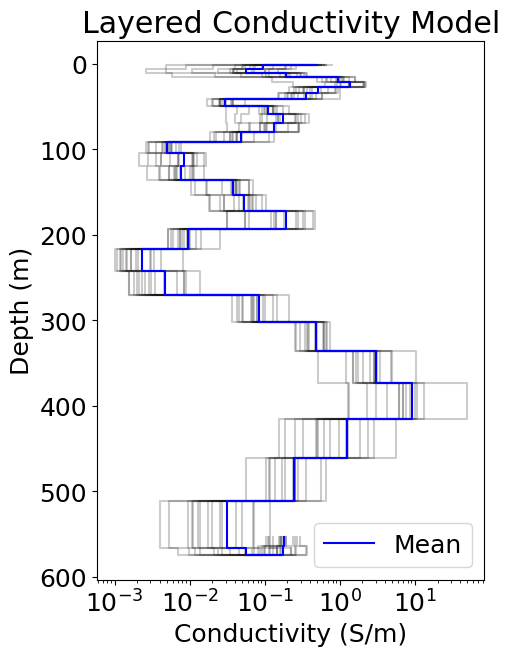

In [84]:
# # Example inputs
# conductivities = [0.01, 0.1, 0.05, 0.2, 0.01]  # Conductivity (S/m) for each layer
# thicknesses = [10, 20, 20, 30, 20]  # Thickness of each layer (m)

# # Compute depths from thicknesses
# depths = np.cumsum(thicknesses)  # Compute layer boundaries
# depths = np.insert(depths, 0, 0)  # Insert surface depth at 0

# # Create step-like depth and conductivity arrays
# depth_plot = np.repeat(plot_depths, 2)  # Duplicate depths for step changes
# conductivity_plot = np.repeat(zmd2_logs[0], 2)  # Duplicate conductivity values

depth_plot = np.repeat(plot_depths, 2)

fig, ax = plt.subplots(figsize=(5, 7))
for log in zmd2_logs:
    conductivity_plot = np.repeat(log,2)
    ax.semilogx(conductivity_plot, depth_plot, drawstyle='steps-post', color='k', alpha=0.2)

mean_cond_plot = np.repeat(mean_cond,2)
mean_true_cond_plot = np.repeat(np.abs(mean_true_cond),2)
ax.semilogx(mean_cond_plot, depth_plot, drawstyle='steps-post', c='b', label='Mean')
# ax.plot(mean_true_cond_plot, depth_plot, drawstyle='steps-post', c='r', label='True Mean')
ax.invert_yaxis()
# Labels and title
ax.set_xlabel('Conductivity (S/m)')
ax.set_ylabel('Depth (m)')
ax.set_title('Layered Conductivity Model')
ax.legend()
# plt.grid()
plt.show()


tanhs (16, 32, 1)
d_pre tf.Tensor(
[[-6.43845558e+00 -3.36016035e+00 -1.96481895e+00 -1.05980527e+00
  -5.69553971e-01 -3.73162121e-01 -2.92864621e-01 -2.47752056e-01
  -2.03933388e-01 -1.53028369e-01 -9.93730277e-02 -5.34867346e-02
  -2.31955517e-02 -8.08285829e-03 -2.02241144e-03 -2.02241144e-03]
 [-5.32117748e+00 -3.01673794e+00 -1.89160049e+00 -1.08899868e+00
  -5.97192883e-01 -3.77544612e-01 -2.89741486e-01 -2.45815068e-01
  -2.04744026e-01 -1.56396642e-01 -1.04115233e-01 -5.77860437e-02
  -2.59387903e-02 -9.35855135e-03 -2.37763044e-03 -2.37763044e-03]
 [-3.91755915e+00 -2.56144309e+00 -1.91539979e+00 -1.36740029e+00
  -9.25373733e-01 -6.49508059e-01 -4.79498535e-01 -3.52399379e-01
  -2.46204615e-01 -1.56725377e-01 -8.66431296e-02 -4.06695716e-02
  -1.60837416e-02 -5.34009701e-03 -1.28841074e-03 -1.28841074e-03]
 [-7.02746439e+00 -2.58038044e+00 -1.39735186e+00 -8.58875871e-01
  -6.18045270e-01 -5.00343800e-01 -4.06518608e-01 -3.18497717e-01
  -2.35769451e-01 -1.57884836e-01 -9.0

c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:606: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(*ylims)


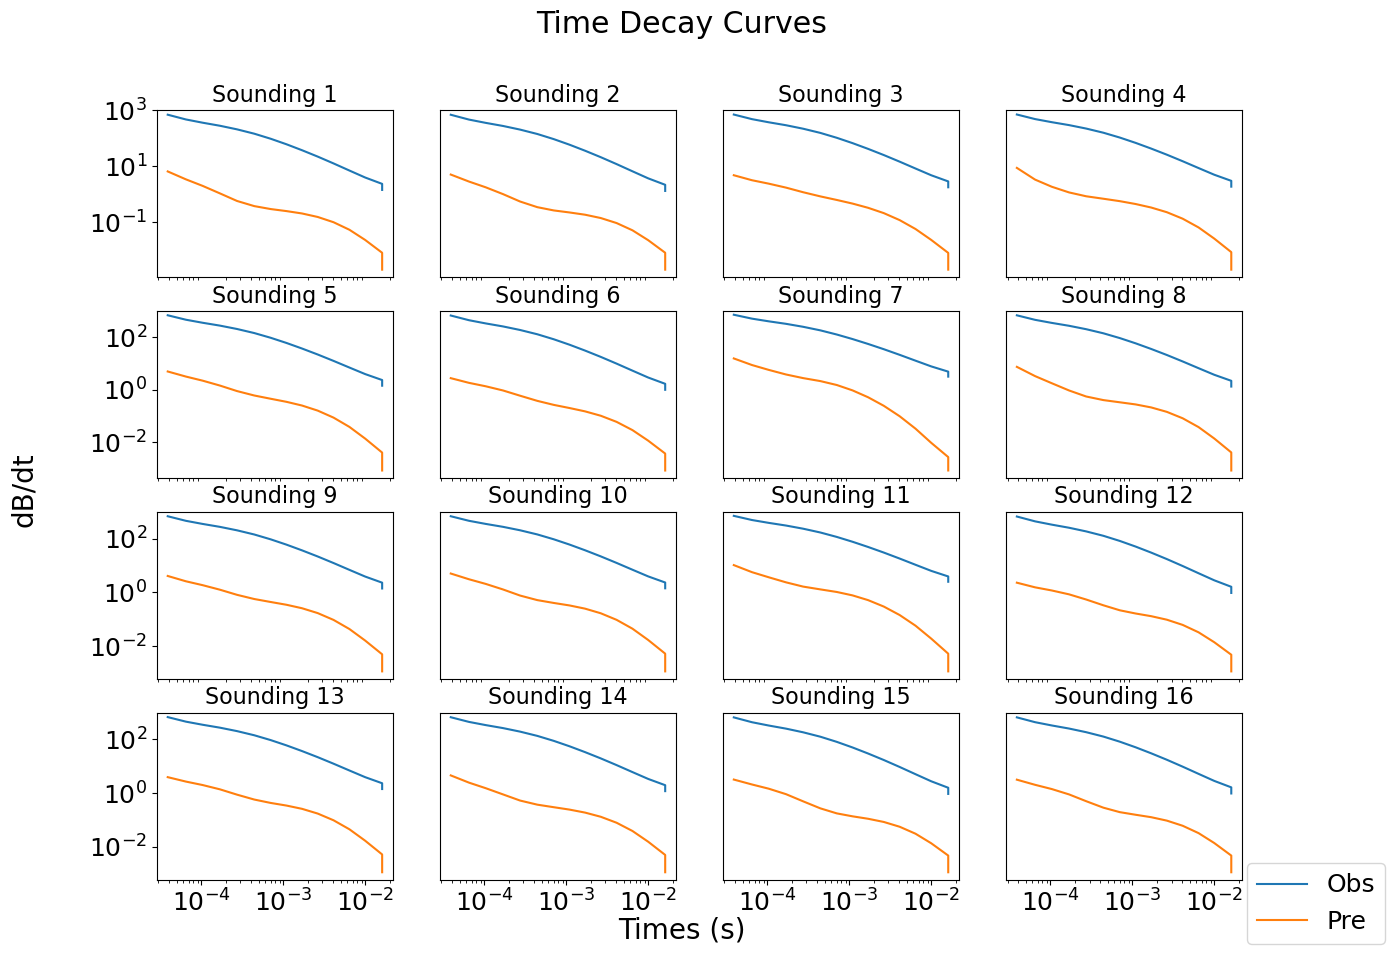

In [73]:
network.plot_data(latent=zmd2)

In [74]:
#log_data_test[0]

In [75]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [76]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [77]:
network.plot_residuals(latent=zmd2, weighted=True)

tanhs (16, 32, 1)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [16,16] vs. [1,32] [Op:Mul] name: 

In [706]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [707]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [708]:
network.data_weights

array([[[5.48595234e+02],
        [6.64350638e+02],
        [1.01762084e+03],
        [2.13942172e+03],
        [6.29904544e+03],
        [1.73081025e+04],
        [1.88571551e+04],
        [1.25243956e+04],
        [1.16432945e+04],
        [2.35853466e+04],
        [3.57238109e+05],
        [1.90076739e+06],
        [1.22610847e+04],
        [1.76403655e+03],
        [6.37863586e+02],
        [3.46907159e+02],
        [2.34253210e+02],
        [1.80179363e+02],
        [1.50882595e+02],
        [1.33918997e+02],
        [1.23786746e+02],
        [1.17700540e+02],
        [1.14096509e+02],
        [1.12024355e+02],
        [1.10881603e+02],
        [1.10282769e+02],
        [1.09986440e+02],
        [1.09848638e+02],
        [1.09789471e+02],
        [1.09770243e+02],
        [1.09783744e+02],
        [1.09777411e+02]]])

In [709]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [710]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [711]:
# print(len(cond2))

In [71]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()